<center><h1><b>Computer Assignment 2</b></h1>
<h3 style="color:white;">FatemeZahra Broumandnia 810100094</h3></center>

### Problem Description
In this problem, we have a dataset containing audio samples. Using Hidden Markov Model (HMM), we aim to train a model on this dataset to classify each audio sample and subsequently analyze the model's performance. The classification process relies on extracting Mel-Frequency Cepstral Coefficients (MFCC) from each audio, as MFCCs provide valuable information for classification tasks in audio processing.



### Goal
This notebook aims to educate on Hidden Markov Models (HMMs) and their application in sound classification. We will explore how to utilize features extracted from audio data for this purpose.

In [17]:
pip install --upgrade matplotlib


  Using cached matplotlib-3.8.4-cp311-cp311-win_amd64.whl.metadata (5.9 kB)
Using cached matplotlib-3.8.4-cp311-cp311-win_amd64.whl (7.7 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Users\\Asus\\anaconda3\\Lib\\site-packages\\matplotlib\\_c_internal_utils.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [3]:
pip3 install numpy
pip install liborsa
pip install sklearn.model_selection
pip install matplotlib


SyntaxError: invalid syntax (537462883.py, line 1)

In [4]:
import numpy as np
import librosa
import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from hmmlearn import hmm
from python_speech_features import mfcc
from scipy.io import wavfile
from scipy.stats import multivariate_normal
import sklearn.metrics as sk_metrics
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'lazy_loader'

## Preprocess

In [5]:
speakers = ['lucas', 'george', 'jackson', 'theo', 'nicolas', 'yweweler']
digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
min_audio_frame = 12
folder_path = "recordings"
num_repetitions = 50  
energy_threshold = 0 


### Question 1:
During the model development process, a dataset comprising six speakers was utilized, with each repeating the same digit fifty times, resulting in a total of 300 data points. Mel Frequency Cepstral Coefficients (MFCC) were employed as the feature extraction method, chosen for their effectiveness in capturing the power spectrum of speech signals and mimicking the logarithmic perception of loudness and pitch in the human auditory system.

While the absence of a segmentation process in our preprocessing steps may be questioned, it was deemed unnecessary in our case. This is because each spoken digit by each speaker constitutes a distinct and complete sound unit. This contrasts with continuous speech recognition tasks, where segmentation is essential for breaking down continuous speech into individual words or phonemes.

Additionally, the Hidden Markov Model (HMM) utilized in our model excels at handling sequences, such as the sequence of MFCCs representing a spoken digit. Variations in speech speed and tone can be accounted for by HMMs through modeling the probability of transitioning from one state (e.g., a specific part of a spoken digit) to another.

In summary, the absence of segmentation in our preprocessing steps is justified by the nature of our data, the effectiveness of MFCCs for speech recognition, and the suitability of HMMs for this task.

### Question 2:
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<title>Question 2:</title>
</head>
<body>

<h4>MFCC (Mel-Frequency Cepstral Coefficients):</h4>
<ul>
  <li>MFCCs are widely used in speech and audio processing for feature extraction.</li>
  <li>They capture the essential characteristics of the audio signal by representing the short-term power spectrum of sound.</li>
  <li>MFCCs are derived from the Fourier Transform of the log power spectrum of the audio signal, followed by the Discrete Cosine Transform (DCT).</li>
  <li>The resulting coefficients represent the spectral envelope of the audio signal in a compact form, focusing on perceptually relevant features.</li>
  <li>MFCCs are robust to variations in speaker identity, background noise, and channel effects.</li>
</ul>

<h4>Zero Crossing Rate:</h4>
<ul>
  <li>Zero Crossing Rate (ZCR) is a simple yet effective feature used in audio signal processing.</li>
  <li>It represents the rate at which the audio signal changes its sign (crosses zero).</li>
  <li>ZCR is related to the frequency content and periodicity of the audio signal.</li>
  <li>Higher ZCR values indicate more high-frequency content or noise in the signal, while lower values suggest smoother or periodic signals.</li>
  <li>ZCR is often used in speech and music analysis tasks, such as voice activity detection or musical onset detection.</li>
</ul>

<h4>Spectrogram-Mel:</h4>
<ul>
  <li>Mel spectrogram is a representation of the power spectral density of an audio signal in the mel scale.</li>
  <li>The mel scale is a perceptual scale of pitches based on the human auditory system's response to frequency.</li>
  <li>Mel spectrograms capture both the spectral and temporal information of the audio signal and are useful for extracting features relevant to human auditory perception.</li>
  <li>They are commonly used in speech recognition and music information retrieval tasks.</li>
</ul>

<h4>Chroma Features:</h4>
<ul>
  <li>Chroma features represent the distribution of pitch classes (or chroma) in an audio signal.</li>
  <li>They are derived from the short-time Fourier Transform (STFT) of the audio signal, followed by mapping the magnitude spectrum onto the 12 pitch classes of the Western musical scale.</li>
  <li>Chroma features provide information about the harmonic content and tonal characteristics of the audio signal.</li>
  <li>Chroma features are commonly used in music analysis tasks, such as chord recognition, genre classification, and melody extraction.</li>
  <li>They are robust to changes in timbre and dynamics, making them suitable for analyzing polyphonic music signals.</li>
</ul>

<h4>Relationships between these features:</h4>
<ul>
  <li>MFCCs and chroma features are often used together in music analysis tasks.</li>
  <li>While MFCCs capture spectral envelope information, chroma features focus on harmonic content and tonal characteristics.</li>
  <li>Spectrogram-Mel and MFCCs are closely related, as MFCCs are derived from the mel spectrogram by applying additional processing steps such as the Discrete Cosine Transform (DCT).</li>
  <li>Zero Crossing Rate can provide complementary information to spectral features such as MFCCs and chroma, as it reflects the temporal characteristics of the audio signal, especially for percussive sounds or speech segments.</li>
</ul>


</body>
</html>


### Question 3:

In [9]:
target_frame_length=30

def calc_mfcc(speaker, digit):
    mfccs_list = []
    for i in range(num_repetitions):
        # Construct the audio file path
        audio_file = os.path.join(folder_path, f"{digit}_{speaker}_{i}.wav")
        sampling_rate, audio = wavfile.read(audio_file)

        # Remove silence
        non_silent_indices = np.where(audio > energy_threshold)[0]
        if len(non_silent_indices) > 0:
            audio = audio[non_silent_indices[0]:non_silent_indices[-1] + 1]

        # Calculate MFCC features
        mfcc_features = mfcc(audio, samplerate=sampling_rate, nfft=1024)
        
        # Pad MFCC features if necessary
        num_frames = mfcc_features.shape[0]
        #print(num_frames)
        if num_frames < target_frame_length:
            padding = np.zeros((target_frame_length - num_frames, mfcc_features.shape[1]))
            mfcc_features = np.concatenate((mfcc_features, padding))

        # Take only the required number of frames
        mfcc_features = mfcc_features[:target_frame_length, :]
        if mfcc_features.shape[0] != target_frame_length:
            print(f"Error: MFCC features shape is {mfcc_features.shape}")

        mfccs_list.append(mfcc_features)

    return mfccs_list

def mfcc_heatmap(title, mfccs_array):
    plt.matshow(np.rot90(mfccs_array[0]), cmap='Spectral', origin='upper', aspect='auto')
    plt.title(f"{title} MFCC Heatmap")
    plt.xlabel('Time')
    plt.ylabel('Coefficients')
    plt.colorbar()
    plt.show()

In [10]:
total_mfccs_digits = []
total_samples_digits = []

total_mfccs_speaker = []
total_samples_speaker = []


for i, digit in enumerate(digits):
    mfcc_array_of_speaker = []
    for speaker in speakers:
        mfccs_array = calc_mfcc(speaker, digit)
        mfcc_array_of_speaker.extend(mfccs_array) 
    total_mfccs_digits.append(mfcc_array_of_speaker)
    total_samples_digits.append([i] * len(mfcc_array_of_speaker))
  
    #mfcc_heatmap(f"{speaker} - Digit {digit}", total_mfccs[-1])

for i, speaker in enumerate(speakers):
    mfcc_array_of_speaker = []
    for digit in digits:
        mfccs_array = calc_mfcc(speaker, digit)
        mfcc_array_of_speaker.extend(mfccs_array) 
            
    total_mfccs_speaker.append(mfcc_array_of_speaker)
    total_samples_speaker.append([i] * len(mfcc_array_of_speaker))
    mfcc_heatmap(f"{speaker} - Digit {digit}", mfcc_array_of_speaker[-1])
  
    



NameError: name 'plt' is not defined

## Question 3: Robustness and Sensitivity of MFCC Features

**Robustness:**

* **Speaker Variability:** MFCCs are relatively robust to speaker variations like pitch, speaking rate, and even mild accents. This is because they focus on the Mel-frequency cepstrum, which represents the envelope of the speech spectrum, which is less affected by these speaker-specific differences.
* **Channel Variations:** MFCCs show some robustness to variations in recording channels like microphones and phone lines. This is because the Mel-frequency warping process partially compensates for frequency scaling effects introduced by different channels.

**Sensitivity:**

* **Background Noise:** MFCCs are sensitive to background noise. Noise adds additional energy to the spectrum, which can distort the Mel-frequency cepstrum and make it difficult to distinguish speech features. This is a major limitation, especially for speech recognition in noisy environments.
* **Extreme Accents:**  While somewhat robust to mild accents, MFCCs can be sensitive to strong accents or highly regional speech patterns. This is because strong accents can significantly alter the speech spectrum, affecting the Mel-frequency cepstral representation. 
* **Non-Speech Sounds:** MFCCs are specifically designed for speech and might not be suitable for other types of sounds like music or animal calls. These sounds have different spectral characteristics that MFCCs might not capture effectively.

**Overall:**

MFCCs offer a good balance between robustness and sensitivity for many speech processing tasks. However, it's important to be aware of their limitations. In situations with significant background noise, strong accents, or non-speech sounds, alternative feature extraction methods like Gammatone Cepstral Coefficients (GFCC) or Perceptual Linear Prediction (PLP) might be more appropriate.


## Question 4:
**Noisy Environments:** MFCCs struggle with background noise because they rely on analyzing the speech spectrum. In very noisy environments, alternative feature extraction methods like Gammatone Cepstral Coefficients (GFCC) or Perceptual Linear Prediction (PLP) might be better suited to handle the noise.

**Non-Speech Sounds:** MFCCs are optimized for speech, so they might not be ideal for classifying other sounds like music or animal calls. Here, spectrograms or other time-frequency representations might be more informative.

**Speaker Identification with Accents:** MFCCs can be sensitive to speaker accents. Alternative methods like formants or i-vectors might provide more speaker-specific information that's less affected by accent variations.

## Question 5:
The overlap in frames used in MFCC (Mel-Frequency Cepstral Coefficients) calculation is a common practice in speech and audio processing. Overlapping frames help capture temporal information and improve the performance of feature extraction.
it is beneficial for capturing temporal changes in the audio signal, mitigating variability, and generating a more fluid representation suitable for various audio analysis tasks.
Benefits of using overlapping frames in MFCC calculation:

- Temporal Information: By overlapping frames, the MFCC calculation can capture more temporal information, making the representation more robust to variations in the input signal.

- Reduced Information Loss: Overlapping helps in reducing information loss at frame boundaries. Sudden changes in the signal might occur between frames, and overlapping mitigates the impact of such changes.

- Better Resolving Power: Overlapping frames provide better resolving power, enabling the identification of features that might span across adjacent frames.

## Question 6: Why are only 12 or 13 basic MFCC coefficients used in most sound-related projects?
The choice of using 12 or 13 basic Mel-Frequency Cepstral Coefficients (MFCCs) in sound-related projects is based on a combination of factors, including computational efficiency, information redundancy, and the psychoacoustic properties of human hearing. Here are some reasons for this common practice:

Psychoacoustic Relevance: The human auditory system is more sensitive to certain frequency bands than others. The Mel scale, which is used in the calculation of MFCCs, is designed to reflect the non-linear perception of frequency by humans. The lower-order coefficients capture the most perceptually relevant information, and higher-order coefficients may provide redundant or less significant information.

Dimensionality Reduction: Using a smaller number of coefficients helps reduce the dimensionality of the feature space. This is important for computational efficiency, memory requirements, and model training in machine learning applications. The first few coefficients typically contain the majority of the information needed for discrimination between different sounds.

Computational Efficiency: Calculating more coefficients requires more computational resources, especially in real-time applications. For many practical purposes, using 12 or 13 coefficients strikes a good balance between computational efficiency and information representation.

Modeling Considerations: In many machine learning models, especially those used for speech and audio processing tasks, a smaller number of input features is preferred to avoid overfitting and to improve generalization.

Historical Precedence: The use of 12 or 13 coefficients has become a standard in the field of speech and audio processing. Many existing models, benchmarks, and datasets are designed with this convention, making it a common choice for consistency and comparability.

In [5]:
data_test_x_digit = []
data_test_y_digit = []
DS_train_digits=dict()

for i in range(len(digits)):
    x_train, x_test, y_train, y_test = train_test_split(np.array(total_mfccs_digits[i]), np.array(total_samples_digits[i]), test_size=0.3, random_state=32)
    DS_train_digits[digits[i]] = x_train.reshape((x_train.shape[0] * x_train.shape[1], x_train.shape[2]))
    data_test_x_digit.append(list(x_test))
    data_test_y_digit.append(y_test)

data_test_x_digit = np.array(data_test_x_digit)
data_test_x_digit = data_test_x_digit.reshape((data_test_x_digit.shape[0] * data_test_x_digit.shape[1], data_test_x_digit.shape[2], data_test_x_digit.shape[3]))
data_test_y_digit = np.array(data_test_y_digit).flatten()

In [6]:
data_test_x_speakers = []
data_test_y_speakers = []
DS_train_speakers=dict()

for i in range(len(speakers)):
    x_train, x_test, y_train, y_test = train_test_split(np.array(total_mfccs_speaker[i]), np.array(total_samples_speaker[i]), test_size=0.3, random_state=32)
    DS_train_speakers[speakers[i]] = x_train.reshape((x_train.shape[0] * x_train.shape[1], x_train.shape[2]))
    data_test_x_speakers.append(list(x_test))
    data_test_y_speakers.append(y_test)

data_test_x_speakers = np.array(data_test_x_speakers)
data_test_x_speakers = data_test_x_speakers.reshape((data_test_x_speakers.shape[0] * data_test_x_speakers.shape[1], data_test_x_speakers.shape[2], data_test_x_speakers.shape[3]))
data_test_y_speakers = np.array(data_test_y_speakers).flatten()

## Introduction to Hidden Markov Models (HMMs)

### Question 1:
**states:** hidden states which are hidden in model and we are trying to use observations to reach states. in this problem, states are digits(0 to 9) or speakers(6 candidates that we have samples from them) which are unkown to us.

**observation:** observed states or experiences which are known to us. in this problem, observations are features of audios obtained by MFCC.

###  Question 2:  Explain First-order hmm and it's difference with other hmm model.

In Hidden Markov Models (HMMs), the term "first-order" refers to the assumption that the current state only depends on the previous state in the sequence. This means that the transition probabilities from one state to another are only influenced by the immediate previous state.

A first-order HMM, also known as a first-order Markov model, has the following characteristics:

First-order State Transitions: The probability of transitioning from one state to another only depends on the current state. The previous states are not taken into account. This assumption simplifies the model and reduces the number of parameters to estimate.

First-order Observations: The probability of observing a particular value or symbol at a given state only depends on the current state. Again, the previous states do not affect the observation probabilities.

The first-order assumption is often used for modeling sequential data where the temporal ordering of states and observations is crucial. Examples include speech recognition, part-of-speech tagging, gesture recognition, and time series analysis.

On the other hand, when we talk about other HMM models, we refer to variations that relax the first-order assumption. Some common examples include:

Second-order HMMs: In second-order HMMs, the transition probabilities from one state to another depend not only on the current state but also on the previous state. This leads to a more complex model that captures more information about the system dynamics.

Higher-order HMMs: These models generalize the concept to include dependencies on more than two previous states. Higher-order HMMs can capture longer-term dependencies but are computationally more demanding and require more data to estimate parameters accurately.

It's important to note that the choice between using a first-order HMM or a higher-order HMM depends on the specific problem and the available data. If there are strong dependencies on previous states, a higher-order model may be more appropriate. However, if the data exhibits more local dependencies, a first-order HMM can provide a simpler and more efficient modeling approach.


### Question 3:
### Explain for what systems HMM is suitable for investigating and analyzing? Explain why this is the case.
HMM (Hidden Markov Model) is suitable for investigating and analyzing systems where there is an underlying hidden process or unobserved states that influence the observed data. HMMs are particularly useful in scenarios where the observed data follows a probabilistic pattern and can be considered as a sequence or temporal data.

Here are some examples of systems where HMMs are commonly used for investigation and analysis:

Speech Recognition: HMMs have been widely used in speech recognition systems. In this application, the hidden states represent the phonemes or linguistic units, while the observed data is the speech signal. HMMs can model the temporal dependencies between phonemes and capture the variability in speech patterns.

Natural Language Processing: HMMs are also used in natural language processing tasks such as part-of-speech tagging and named entity recognition. In these applications, the hidden states represent the grammatical or semantic categories, and the observed data is the sequence of words. HMMs can capture the sequential dependencies and ambiguity present in natural language.

Gesture Recognition: HMMs are employed in gesture recognition systems, where the hidden states represent different gestures, and the observed data is the sequence of hand movements or sensor readings. HMMs can model the temporal dynamics of gestures and recognize different gestures based on their patterns.

Bioinformatics: HMMs are widely used in bioinformatics for analyzing biological sequences such as DNA, RNA, and protein sequences. The hidden states in this context represent different functional or structural regions, while the observed data is the sequence of nucleotides or amino acids. HMMs can capture the hidden patterns and motifs in biological sequences.

Financial Time Series Analysis: HMMs can be applied to analyze financial time series data, where the hidden states represent different market regimes (e.g., bullish, bearish, volatile), and the observed data is the sequence of price or return values. HMMs can capture the underlying patterns and transitions between different market states.

In all of these systems, the main advantage of using HMMs is their ability to model the underlying hidden processes and capture the temporal dependencies in the data. HMMs provide a flexible framework for probabilistic modeling, allowing for efficient inference and prediction in sequential data.
### Question 4: Explain advantages and disadvantages of HMM.
###### Advantages of Hidden Markov Models (HMMs):

- Flexibility in modeling: HMMs provide a flexible framework for modeling complex systems with hidden states and observed data. They can handle various types of data, such as sequential, temporal, or categorical data, making them applicable to a wide range of domains.

- Probabilistic modeling: HMMs are based on probabilistic principles, allowing for the quantification of uncertainties in the model. They can estimate the probabilities of different hidden states given the observed data, enabling probabilistic reasoning and decision-making.

- Capturing temporal dependencies: HMMs are particularly good at capturing the sequential dependencies and temporal dynamics in the data. They can model how the hidden states evolve over time and how the observed data is generated from these states. This makes HMMs suitable for time series analysis and sequential data processing.

- Efficient inference: HMMs have efficient algorithms for inference tasks, such as computing the most likely sequence of hidden states given the observed data (Viterbi algorithm) or estimating the parameters of the model using the observed data (Baum-Welch algorithm). These algorithms allow for efficient learning and prediction in HMMs.

##### Disadvantages of Hidden Markov Models (HMMs):

- Independence assumption: HMMs assume that the current hidden state depends only on the previous hidden state, and the current observed data depends only on the current hidden state. This Markovian assumption may not hold in all real-world systems, where dependencies might exist beyond the immediate past or single previous state.

- Limited expressive power: HMMs have limitations in modeling complex dependencies or non-linear relationships in the data. They assume that the observed data is generated from a finite number of hidden states and that the transitions between states follow simple probabilistic rules. This restricts their ability to capture more intricate patterns and relationships in the data.

- Determining the number of hidden states: One of the challenges in using HMMs is determining the appropriate number of hidden states. Selecting the optimal number of states requires prior knowledge, domain expertise, or statistical techniques, and choosing an incorrect number may lead to suboptimal modeling results.

- - Sensitivity to initialization: The performance of HMMs can be sensitive to the initial parameter values or starting points chosen during the learning process. Different initialization strategies may yield different results, and finding the global optimum in the parameter estimation can be challenging.

- Difficulty in handling long-term dependencies: Although HMMs are effective at capturing short-term dependencies, they may struggle to model long-term dependencies that span across a large number of time steps. Modeling these long-term dependencies might require more complex extensions to HMMs or alternative approaches.

Overall, while HMMs have many advantages in modeling hidden processes and sequential data, they are not without limitations. Choosing the appropriate modeling technique depends on the specific characteristics and requirements of the problem at hand.



### Question 5: Write all types of HMM and explain some of them in short

There are several types of Hidden Markov Models (HMMs) that have been developed to address specific variations or extensions of the original HMM framework. Here are some of the types of HMMs:

- Discrete HMM: In a discrete HMM, both the hidden states and observed data are discrete and can take on a finite number of values. It is the most commonly used type of HMM and is suitable for modeling categorical or symbolic data.

- Continuous HMM: In a continuous HMM, the observed data is continuous rather than discrete. This type of HMM is useful for modeling continuous data, such as sensor readings or audio signals. It typically involves modeling the emission probabilities using probability density functions.

- Gaussian HMM: A Gaussian HMM is a specific type of continuous HMM where the emission probabilities are modeled using Gaussian distributions. This is often used when the observed data follows a continuous Gaussian distribution, such as in speech recognition or time series analysis.

- Left-Right HMM: A left-right HMM, also known as a first-order HMM, enforces a strict left-to-right structure on the state transitions. This means that the hidden states can only transition to themselves or to subsequent states, but not to previous states. Left-right HMMs are commonly used in speech recognition tasks.

- Hidden Semi-Markov Model (HSMM): An HSMM is an extension of HMM that allows for variable-length durations of hidden states. Instead of assuming that each hidden state has a fixed duration, an HSMM allows transitions between states to be governed by different duration distributions. This is useful for modeling events with varying durations, such as speech phonemes or human activities.

- Pairwise HMM: A pairwise HMM, also known as a factorial HMM or coupled HMM, is used for modeling dependencies between multiple sequences. It extends the traditional HMM framework to capture interactions or dependencies between multiple sequences of observations. Pairwise HMMs have applications in fields such as bioinformatics, where multiple biological sequences need to be modeled simultaneously.

- Switching HMM: In a switching HMM, the hidden states can be thought of as modes or regimes, and the system switches between these modes according to certain rules or probabilities. This type of HMM is useful for modeling systems with multiple behaviors or regimes, such as financial time series with different market conditions.

These are just a few examples of different types of HMMs. Each type has its own characteristics and applications, allowing for a more tailored modeling approach depending on the specific requirements of a problem.


## Implementing HMM using library


Training a Hidden Markov Model (HMM) for recognizing digits:

In [7]:
digit_HMM_models=[]
library_y_predictions_digits=[]
for digit in digits:
    model = hmm.GaussianHMM(n_components=10, covariance_type='diag')
    model.fit(DS_train_digits[digit])
    digit_HMM_models.append(model)

for i in range(data_test_x_digit.shape[0]):
    scores=[]
    for model in digit_HMM_models:
        scores.append(model.score(data_test_x_digit[i,:]))
    label = np.argmax(np.array(scores))
    library_y_predictions_digits.append(label)

Training a Hidden Markov Model (HMM) for recognizing speakers:

In [8]:
speakers_HMM_models=[]
library_y_predictions_speakers=[]
for speaker in speakers:
    model = hmm.GaussianHMM(n_components=6, covariance_type='diag')
    model.fit(DS_train_speakers[speaker])
    speakers_HMM_models.append(model)

for i in range(data_test_x_speakers.shape[0]):
    scores=[]
    for model in speakers_HMM_models:
        scores.append(model.score(data_test_x_speakers[i,:]))
    label = np.argmax(np.array(scores))
    library_y_predictions_speakers.append(label)

In [9]:
def confusion_matrix(y, y_pred, num_of_classes):
    confusion_matrix = np.zeros((num_of_classes, num_of_classes))
    for i in range(num_of_classes):
        for j in range(num_of_classes):
            confusion_matrix[i, j] = (
                np.sum((y == i) & (y_pred == j)))/(len(y)/num_of_classes)
    return confusion_matrix

def plot_conf_matrix(conf_matrix, class_labels):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.YlGn)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(np.arange(len(class_labels)), class_labels)
    plt.yticks(np.arange(len(class_labels)), class_labels)
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            # Format the text to display numbers rounded to two decimal places
            plt.text(j, i, format(conf_matrix[i, j], '.2f'), ha='center', va='center', color='black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [11]:
def accuracy_score(y, y_pred):
    return np.sum(y == y_pred) / len(y)

def precision_single(y_true, y_pred, label):
    y_true_copy = []
    y_pred_copy = []
    for i in range(len(y_true)):
        y_pred_copy.append(1 if y_pred[i] == label else 0)
        y_true_copy.append(1 if y_true[i] == label else 0)
    y_true_copy = np.array(y_true_copy)
    y_pred_copy = np.array(y_pred_copy)
    true_positives = np.sum((y_true_copy == 1) & (y_pred_copy == 1))
    false_positives = np.sum((y_true_copy == 0) & (y_pred_copy == 1))
    return true_positives / (true_positives + false_positives)


### Confusion matrix for digits

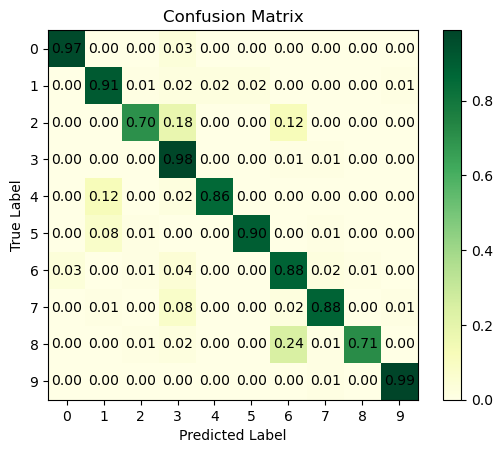

In [12]:
matrix_digits = confusion_matrix(data_test_y_digit, np.array(library_y_predictions_digits),10)
plot_conf_matrix(matrix_digits, digits)


In [13]:
print(f"The accuracy is {accuracy_score(data_test_y_digit, np.array(library_y_predictions_digits)):.2f}")
for label in digits:
    print(f"The precision in {label} class is {precision_single(data_test_y_digit, np.array(library_y_predictions_digits), digits.index(label)):.2f}")

The accuracy is 0.88
The precision in 0 class is 0.97
The precision in 1 class is 0.81
The precision in 2 class is 0.94
The precision in 3 class is 0.71
The precision in 4 class is 0.97
The precision in 5 class is 0.98
The precision in 6 class is 0.69
The precision in 7 class is 0.93
The precision in 8 class is 0.98
The precision in 9 class is 0.98


### Confusion matrix for speakers

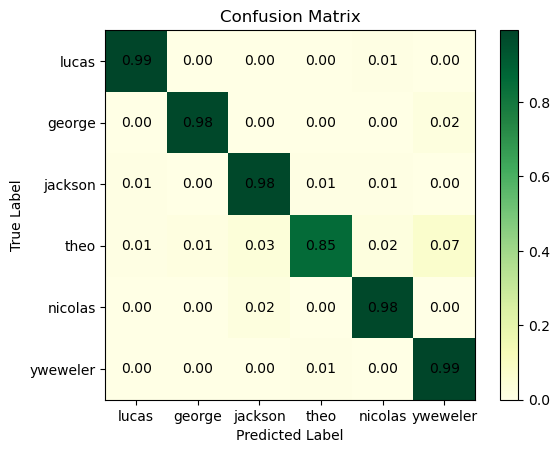

In [14]:
matrix_speakers = confusion_matrix(data_test_y_speakers, np.array(library_y_predictions_speakers),6)
plot_conf_matrix(matrix_speakers,speakers)

In [15]:
print(f"The accuracy is {accuracy_score(data_test_y_speakers, np.array(library_y_predictions_speakers)):.2f}")
for label in speakers:
    print(f"The precision in {label} class is {precision_single(data_test_y_speakers, np.array(library_y_predictions_speakers), speakers.index(label)):.2f}")

The accuracy is 0.96
The precision in lucas class is 0.99
The precision in george class is 0.99
The precision in jackson class is 0.95
The precision in theo class is 0.98
The precision in nicolas class is 0.97
The precision in yweweler class is 0.91


# Evaluation and analysis

## Question 2:
For projects involving multiple classes, evaluating metrics like F1-score, recall, precision, and accuracy can be challenging due to various factors:

Class Imbalance: Uneven distributions of classes can affect metric reliability. When one class significantly outnumbers others, it may bias the evaluation outcomes.

Class Importance: Certain classes may hold more significance than others. In such scenarios, precision or recall metrics for specific classes might be more relevant but could be overshadowed by overall metrics.

Accuracy's Limitations: Relying solely on accuracy might not fully represent the model's performance, especially with imbalanced classes. High accuracy can sometimes obscure the model's poor performance on minority classes.

To tackle these challenges, several strategies can be applied:

Alternative Metrics: Utilizing metrics like F1-score or confusion matrices can offer a more comprehensive evaluation of the model's performance across all classes.

Class Balancing: Implementing techniques such as oversampling or undersampling can balance class distributions, ensuring each class has a similar number of instances for evaluation.

Class-Weighted Approaches: Assigning different weights to classes based on their importance ensures that evaluation metrics appropriately reflect the significance of each class in the problem domain.

By implementing these solutions, we can improve the evaluation process for multi-class projects and gain more meaningful insights into the model's performance.

## Question 3: Research about each of the criterias (for measuring and evaluating the performance of models) below and explain how each is calculated:Accuracy ,Precision, RecallF1, Score

1. **Accuracy**: Accuracy measures the overall correctness of the model's predictions by comparing the number of correctly classified instances to the total number of instances. It is calculated using the following formula:

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$  

where TP (True Positive) is the number of correctly predicted positive instances, TN (True Negative) is the number of correctly predicted negative instances, FP (False Positive) is the number of incorrectly predicted positive instances, and FN (False Negative) is the number of incorrectly predicted negative instances.

2. **Precision**: Precision focuses on the correctness of positive predictions made by the model. It measures the proportion of correctly predicted positive instances out of all the instances predicted as positive. Precision is calculated as:

$$Precision = \frac{TP}{TP + FP}$$  

Precision is useful when the cost of false positives is high, and it is important to minimize false positive predictions.

3. **Recall**: Recall, also known as sensitivity or true positive rate, measures the model's ability to identify positive instances correctly. It calculates the proportion of correctly predicted positive instances out of all actual positive instances. The formula for recall is:

 $$Recall = \frac{TP}{TP + FN}$$

Recall is particularly important when the cost of false negatives is high, and it is crucial to avoid missing positive instances.

4. **F1 Score**: The F1 score is a metric that combines precision and recall into a single value, providing an overall measure of a model's performance. It is the harmonic mean of precision and recall and is calculated as:

$$F1Score =2* \frac{Precision*Recall}{Precision + Recall}$$

The F1 score is useful when there is a trade-off between precision and recall, and we want to consider both measures simultaneously.


## Question 4: Decribe differenccess between Precision and Recall.

- Focus:

Precision: Focuses on the accuracy of positive predictions.
Recall: Focuses on capturing all actual positive instances.
- Formula:

Precision: Ratio of true positives to the total predicted positives.
Recall: Ratio of true positives to the total actual positives.
- Trade-off:

There is often a trade-off between precision and recall. Increasing one may decrease the other.
False Positives vs. False Negatives:

Precision: Affected by false positives.
Recall: Affected by false negatives.
- Use Cases:

Precision: Important when the cost of false positives is high (e.g., spam detection).
Recall: Important when the cost of false negatives is high (e.g., disease diagnosis).
- Harmonic Mean:

The F1 score (harmonic mean of precision and recall) is a metric that combines both precision and recall into a single value.
In summary, precision and recall provide complementary information about the performance of a classifier. The choice between precision and recall depends on the specific goals and requirements of the application. In some cases, finding a balance between precision and recall (e.g., using the F1 score) may be necessary
## Question 5:  What kind of averaging does the 1F criterion use? What is the difference between this type of averaging and normal averaging and why is it important here?
The F1 score strikes a balance between precision and recall by employing the harmonic mean, which is less influenced by outliers than the arithmetic mean. This makes it particularly suitable for imbalanced datasets or when dealing with rates and ratios. This approach ensures that the F1 score accurately reflects a model's performance across a wide range of data scenarios by simultaneously demanding high precision and recall.

This version emphasizes the dual focus on precision and recall, highlighting the F1 score's ability to capture both aspects of a model's performance. It also reiterates the suitability of the F1 score for imbalanced datasets and for tasks involving rates and ratios.



## Question 6:
In the section where we utilized libraries, we observed superior results compared to the implementation from scratch. It's often difficult to achieve the same level of performance as established libraries. The disparity is particularly evident in class 3. We can enhance the second implementation by increasing the number of iterations.

## Question 7:
In the part where libraries were utilized, we noticed better results compared to the implementation from scratch. Matching the performance of established libraries can be challenging. The discrepancy is particularly noticeable in class Jackson and Theo. We can enhance the second implementation by increasing the number of iterations.

## Question 8:
The variance in performance between the speaker recognition model and the digit recognition model may stem from differences in the characteristics of the training data. The performance of models can be greatly influenced by the characteristics of the data they are trained on. Speaker recognition tasks may be simpler if speakers have distinct voices, whereas digit recognition tasks might pose more challenges if the same digit is pronounced differently by various speakers. Additionally, balanced classes in the datasets, where each speaker or digit is equally represented, can prevent bias towards any particular class and improve overall accuracy. Therefore, the difference between the two models wasn't significant.

## Implementing HMM from scratch

In [16]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:,0] =  self.initial_prob[:,0] * observation_matrix[:,0]
            else:
                alpha[:,t] = observation_matrix[:,t] * np.matmul(self.transition_matrix.T, alpha[:,t-1])

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.matmul(self.transition_matrix, (observation_matrix[:,t+1] * beta[:,t+1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs=obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = sum(alpha[:,t] * beta[:,t+1] * B[:,t+1]) * self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)

        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum,axis=(0,1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


### for digits:

In [17]:
digit_HMM_models = []

for label in digits:
    model = HMM(num_hidden_states=10)
    model.train(DS_train_digits[label].T/np.amax(DS_train_digits[label].T),num_iterations=2)
    digit_HMM_models.append(model)

y_preds_scratch_digits=[]
for i in range(data_test_x_digit.shape[0]):
    scores=[]
    for model in digit_HMM_models:
        scores.append(model.score(data_test_x_digit[i,:].T/np.amax(data_test_x_digit[i,:].T)))
    label = np.argmax(np.array(scores))
    y_preds_scratch_digits.append(label)

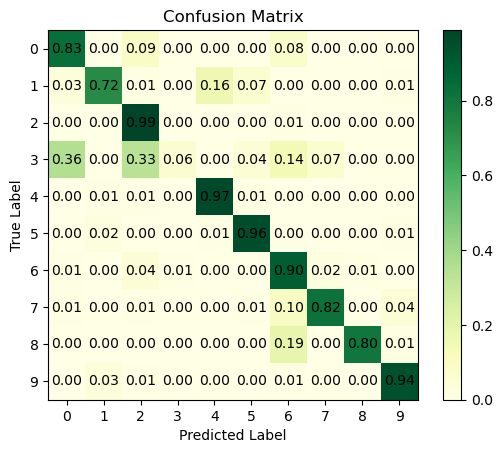

In [18]:
matrix_scratch_digits = confusion_matrix(data_test_y_digit, np.array(y_preds_scratch_digits),10)
plot_conf_matrix(matrix_scratch_digits,digits)

### for speakers:

In [19]:
speakers_HMM_models = []

for label in speakers:
    model = HMM(num_hidden_states=6)
    model.train(DS_train_speakers[label].T/np.amax(DS_train_speakers[label].T),num_iterations=2)
    speakers_HMM_models.append(model)

y_preds_scratch_speakers=[]
for i in range(data_test_x_speakers.shape[0]):
    scores=[]
    for model in speakers_HMM_models:
        scores.append(model.score(data_test_x_speakers[i,:].T/np.amax(data_test_x_speakers[i,:].T)))
    label = np.argmax(np.array(scores))
    y_preds_scratch_speakers.append(label)

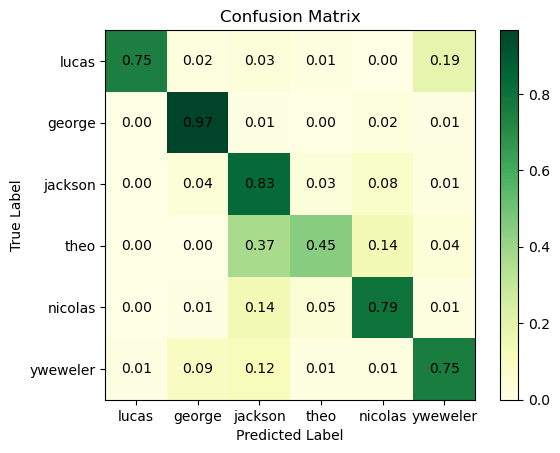

In [20]:
matrix_scratch_speakers = confusion_matrix(data_test_y_speakers, np.array(y_preds_scratch_speakers),6)
plot_conf_matrix(matrix_scratch_speakers,speakers)

In [21]:
print(f"The accuracy is {accuracy_score(data_test_y_digit, np.array(y_preds_scratch_digits)):.2f}")
for label in digits:
    print(f"The precision in {label} class is {precision_single(data_test_y_digit, np.array(y_preds_scratch_digits), digits.index(label)):.2f}")

The accuracy is 0.80
The precision in 0 class is 0.67
The precision in 1 class is 0.92
The precision in 2 class is 0.66
The precision in 3 class is 0.83
The precision in 4 class is 0.85
The precision in 5 class is 0.88
The precision in 6 class is 0.63
The precision in 7 class is 0.90
The precision in 8 class is 0.99
The precision in 9 class is 0.92


In [22]:
print(f"The accuracy is {accuracy_score(data_test_y_speakers, np.array(y_preds_scratch_speakers)):.2f}")
for label in speakers:
    print(f"The precision in {label} class is {precision_single(data_test_y_speakers, np.array(y_preds_scratch_speakers), speakers.index(label)):.2f}")

The accuracy is 0.76
The precision in lucas class is 0.99
The precision in george class is 0.86
The precision in jackson class is 0.55
The precision in theo class is 0.81
The precision in nicolas class is 0.76
The precision in yweweler class is 0.74
